# Batch Normalization in Pytorch

In [13]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

## Prepare dataset
- MNIST dataset
  - 28x28 image

In [14]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# get the MNIST datasets
# transform: convert data to FloatTensor
train_data = datasets.MNIST(root='data', train=True, download=True,
                            transform=ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True,
                           transform=ToTensor())

# number of samples per batch
batch_size = 64

# DataLoader
# num_workers: number of subprocesses to use for data loading
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=0)

In [15]:
print(len(train_loader))
print(len(test_loader))

938
157


### Visualize the data

(28, 28)


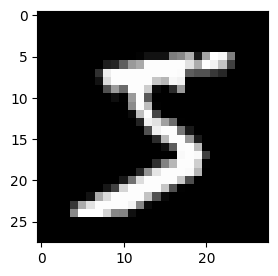

In [16]:
# one batch of training images
images, labels = next(iter(train_loader))
# to numpy array
images = images.numpy()

# one image from the batch
img = np.squeeze(images[0])
# image shape
print(img.shape)

fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Model class
- a simple MLP for classification

- add batch normalization to layers
  - layers with batch normalization do **not** include a bias term
  - use `nn.BatchNorm1d()` to operate on linear layer outputs
  - add the batch normalization layer **before** calling the activation function


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, use_batch_norm, input_size=784, hidden_dim=256, output_size=10):
        # init super(=nn.Module)
        super(NeuralNet, self).__init__()

        # input_size: number of features (28x28 image)
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        # output_size: number of classes (0~9)
        self.output_size = output_size
        # use_batch_norm: whether or not this network uses batch norm
        self.use_batch_norm = use_batch_norm

        # define hidden linear layers
        # layers with batch_norm -> no bias term
        ## Layer 1
        # use batch norm
        if use_batch_norm:
            self.fc1 = nn.Linear(input_size, hidden_dim*2, bias=False)
            self.batch_norm1 = nn.BatchNorm1d(hidden_dim*2)
        # do not use batch norm
        else:
            self.fc1 = nn.Linear(input_size, hidden_dim*2)

        ## Layer 2
        # use batch norm
        if use_batch_norm:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
            self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        # do not use batch norm
        else:
            self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)

        ## Layer 3 (output layer)
        self.fc3 = nn.Linear(hidden_dim, output_size)


    def forward(self, x):
        # flatten image (reshape)
        x = x.view(-1, 28*28)

        ## Layer 1
        # linear
        x = self.fc1(x)
        # batch norm
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        # activation function
        x = F.relu(x)

        ## Layer 2
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)

        ## Layer 3: linear (no batch norm, activation function)
        x = self.fc3(x)

        return x


### Create two different models

* `net_batchnorm`: **with** batch normalization
* `net_no_norm`: **without** batch normalization (a plain MLP)

In [18]:
net_batchnorm = NeuralNet(use_batch_norm=True)
net_no_norm = NeuralNet(use_batch_norm=False)

# print models
print(net_batchnorm)
print()
print(net_no_norm)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=False)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Train
- cross entropy loss
- stochastic gradient descent(SGD) for optimization

In [19]:
def train(model, n_epochs=10):
    # number of epochs to train model (default=10)
    n_epochs = n_epochs

    # track loss
    losses = []

    # loss function
    criterion = nn.CrossEntropyLoss()

    # optimizer (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()

    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients
            optimizer.zero_grad()

            # forward
            output = model(data)

            # loss
            loss = criterion(output, target)

            # backward
            loss.backward()
            # update parameter: a single optimization step
            optimizer.step()

            # update train loss
            # loss.item(): get scalar loss value (average batch loss)
            train_loss += loss.item()
            batch_count +=1

        # loss
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss/batch_count))

    # return all recorded batch losses
    return losses

### Compare models

In [20]:
# losses (with batch norm)
losses_batchnorm = train(net_batchnorm)

Epoch: 1 	Training Loss: 0.393225
Epoch: 2 	Training Loss: 0.163401
Epoch: 3 	Training Loss: 0.113395
Epoch: 4 	Training Loss: 0.084088
Epoch: 5 	Training Loss: 0.064032
Epoch: 6 	Training Loss: 0.049439
Epoch: 7 	Training Loss: 0.038569
Epoch: 8 	Training Loss: 0.030373
Epoch: 9 	Training Loss: 0.024097
Epoch: 10 	Training Loss: 0.019302


In [21]:
# losses (without batch norm)
losses_no_norm = train(net_no_norm)

Epoch: 1 	Training Loss: 1.557275
Epoch: 2 	Training Loss: 0.495918
Epoch: 3 	Training Loss: 0.372220
Epoch: 4 	Training Loss: 0.327937
Epoch: 5 	Training Loss: 0.300059
Epoch: 6 	Training Loss: 0.278639
Epoch: 7 	Training Loss: 0.260513
Epoch: 8 	Training Loss: 0.244380
Epoch: 9 	Training Loss: 0.229659
Epoch: 10 	Training Loss: 0.215995


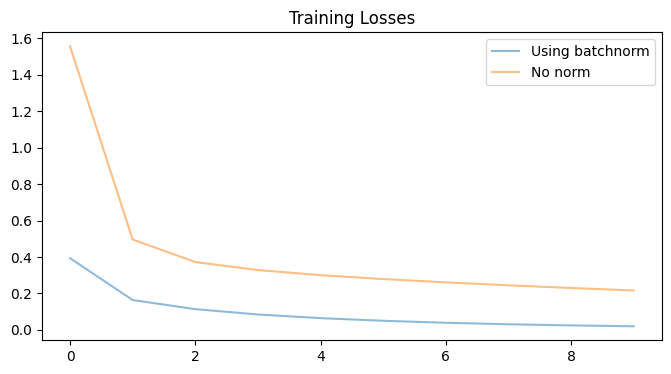

In [28]:
# compare
fig, ax = plt.subplots(figsize=(8,4))
plt.plot(losses_batchnorm, label='Using batchnorm', alpha=0.5)
plt.plot(losses_no_norm, label='No norm', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Test


In [29]:
def test(model, train):
    # zero array (size 10)
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0

    # train parameter -> set model to train or evaluation mode
    if(train==True):
        model.train()
    if(train==False):
        model.eval()

    # loss
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward
        output = model(data)

        # loss
        loss = criterion(output, target)

        # average test loss
        test_loss += loss.item()*batch_size
        # output -> predict class(target) using max prob
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i),
                                                             100 * class_correct[i] / class_total[i],
                                                             np.sum(class_correct[i]),
                                                             np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (str(i)))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                          np.sum(class_correct), np.sum(class_total)))

### Train mode VS Evaluation mode

Setting a model to evaluation mode is important for models with batch normalization layers

- Train mode: batch normalization layers will use **batch** statistics to calculate the batch norm
- Evaluation mode: use the estimated **population** mean and variance from the entire training set
  -> give us increased performance on this test data

In [30]:
# test (batch norm) in train mode
test(net_batchnorm, train=True)

Test Loss: 0.082439

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 96% (997/1032)
Test Accuracy of     3: 97% (982/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 97% (869/892)
Test Accuracy of     6: 97% (936/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 97% (945/974)
Test Accuracy of     9: 96% (976/1009)

Test Accuracy (Overall): 97% (9750/10000)


In [31]:
# test (batch norm) in eval mode
test(net_batchnorm, train=False)

Test Loss: 0.069304

Test Accuracy of     0: 98% (968/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (954/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 97% (932/958)
Test Accuracy of     7: 96% (990/1028)
Test Accuracy of     8: 96% (941/974)
Test Accuracy of     9: 98% (989/1009)

Test Accuracy (Overall): 97% (9768/10000)


In [32]:
# test (without batch norm) in eval mode
test(net_no_norm, train=False)

Test Loss: 0.207962

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 98% (1114/1135)
Test Accuracy of     2: 91% (944/1032)
Test Accuracy of     3: 93% (940/1010)
Test Accuracy of     4: 93% (916/982)
Test Accuracy of     5: 92% (822/892)
Test Accuracy of     6: 95% (913/958)
Test Accuracy of     7: 92% (952/1028)
Test Accuracy of     8: 91% (890/974)
Test Accuracy of     9: 93% (941/1009)

Test Accuracy (Overall): 93% (9398/10000)


- batch norm model's accuracy: **evaluation mode** should give a small improvement (better than train mode)

- using batch norm layers shows a marked improvement in overall accuracy when compared with the no-normalization model